# CNN Using Pretrained Models

Text and explanations credit to: Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

### Dependencies

In [ ]:
!pip install torchinfo
! pip install gdown  # download large file from Google Drive

In [ ]:
import os
import shutil
import glob
import random
import concurrent
import zipfile
import torch
import PIL
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Image
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Convnet Models from torchvision


----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.

## Load datasetL Dog&Cat

In [ ]:
! gdown https://drive.google.com/uc?id=1ItGv65UmiQKnett7vxY1qNPTXRg4hSfW

Downloading...
From: https://drive.google.com/uc?id=1ItGv65UmiQKnett7vxY1qNPTXRg4hSfW
To: /content/dog_cat.zip
100% 570M/570M [00:06<00:00, 86.3MB/s]


In [ ]:
with zipfile.ZipFile('/content/dog_cat.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
# cwd
cwd = os.getcwd()

# dirs
dog_cat_dir = os.path.join(cwd, 'dog_cat')
if not os.path.exists(dog_cat_dir):
    os.mkdir(dog_cat_dir)

cat_dir = os.path.join(dog_cat_dir, 'cat')
if not os.path.exists(cat_dir):
    os.mkdir(cat_dir)
    
dog_dir = os.path.join(dog_cat_dir, 'dog')
if not os.path.exists(dog_dir):
    os.mkdir(dog_dir)

# sample random 1000 pics for cats & dogs
cat_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'cat.*.jpg')), size=1000, replace=False)
dog_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'dog.*.jpg')), size=1000, replace=False)

# move to dir
def move_to_folder(scr_file, des_folder):
    des_name = os.path.basename(scr_file)
    shutil.copyfile(scr_file, os.path.join(des_folder, des_name))
# cats
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, cat_dir) for file_name in cat_pics]
# dogs
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, dog_dir) for file_name in dog_pics]

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

In [ ]:
images_list = glob.glob(os.path.join(dog_cat_dir, '*', '*.jpg'))
# label: 0 for cat, 1 for dog
def extract_class(img_path):
    base_path = os.path.basename(img_path)
    return base_path.split('.')[0]

labels = [0 if extract_class(cur_path) == 'cat' else 1 for cur_path in images_list]

In [ ]:
transformations = transforms.Compose([transforms.Resize((150, 150)),  # resize to input shape of our CNN
                                      transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                      transforms.RandomRotation(40),
                                      transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

In [ ]:
dog_cat_dataset = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=transformations)

In [ ]:
split_size = (np.array([0.6, 0.2, 0.2]) * len(dog_cat_dataset)).round().astype(np.int)
train_data, valid_data, test_data = random_split(dog_cat_dataset, split_size)

## Train Function

In [ ]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=256):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
    
    return history

## Feature extraction


Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.


Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model

## Load models from torch.vision

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with [`torchvision.models`](https://pytorch.org/vision/stable/models.html#torchvision.models.alexnet). Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of [`torchvision.models`](https://pytorch.org/vision/stable/models.html#torchvision.models.alexnet):

* AlexNet
* VGG-11
* VGG-16
* ResNet-18
* SqueezeNet 1.0
* MGoogleNet

Let's instantiate the [VGG16](https://pytorch.org/vision/stable/models.html#torchvision.models.vgg16) model:

In [ ]:
import torchvision.models as models

VGG_model = models.vgg16(pretrained=True)

`pretrained=True` will load the pretrained set of weights of VGG16 model. If `pretrained=False`, then only the structure will be loaded.  

  
Here's the detail of the architecture of the VGG16 convolutional base, it's very similar to the simple convnets that you are already:

In [ ]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(VGG_model, (10, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [10, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [10, 64, 150, 150]        1,792
│    └─ReLU: 2-2                         [10, 64, 150, 150]        --
│    └─Conv2d: 2-3                       [10, 64, 150, 150]        36,928
│    └─ReLU: 2-4                         [10, 64, 150, 150]        --
│    └─MaxPool2d: 2-5                    [10, 64, 75, 75]          --
│    └─Conv2d: 2-6                       [10, 128, 75, 75]         73,856
│    └─ReLU: 2-7                         [10, 128, 75, 75]         --
│    └─Conv2d: 2-8                       [10, 128, 75, 75]         147,584
│    └─ReLU: 2-9                         [10, 128, 75, 75]         --
│    └─MaxPool2d: 2-10                   [10, 128, 37, 37]         --
│    └─Conv2d: 2-11                      [10, 256, 37, 37]         29

To apply the model on our cat&dog dataset, we will need to:


1.   Change the classifier
2.   Determine if we want to freeze the weights or not(pre-trained or fine tuning)



## Using the pre-trained model: Weights are frozen

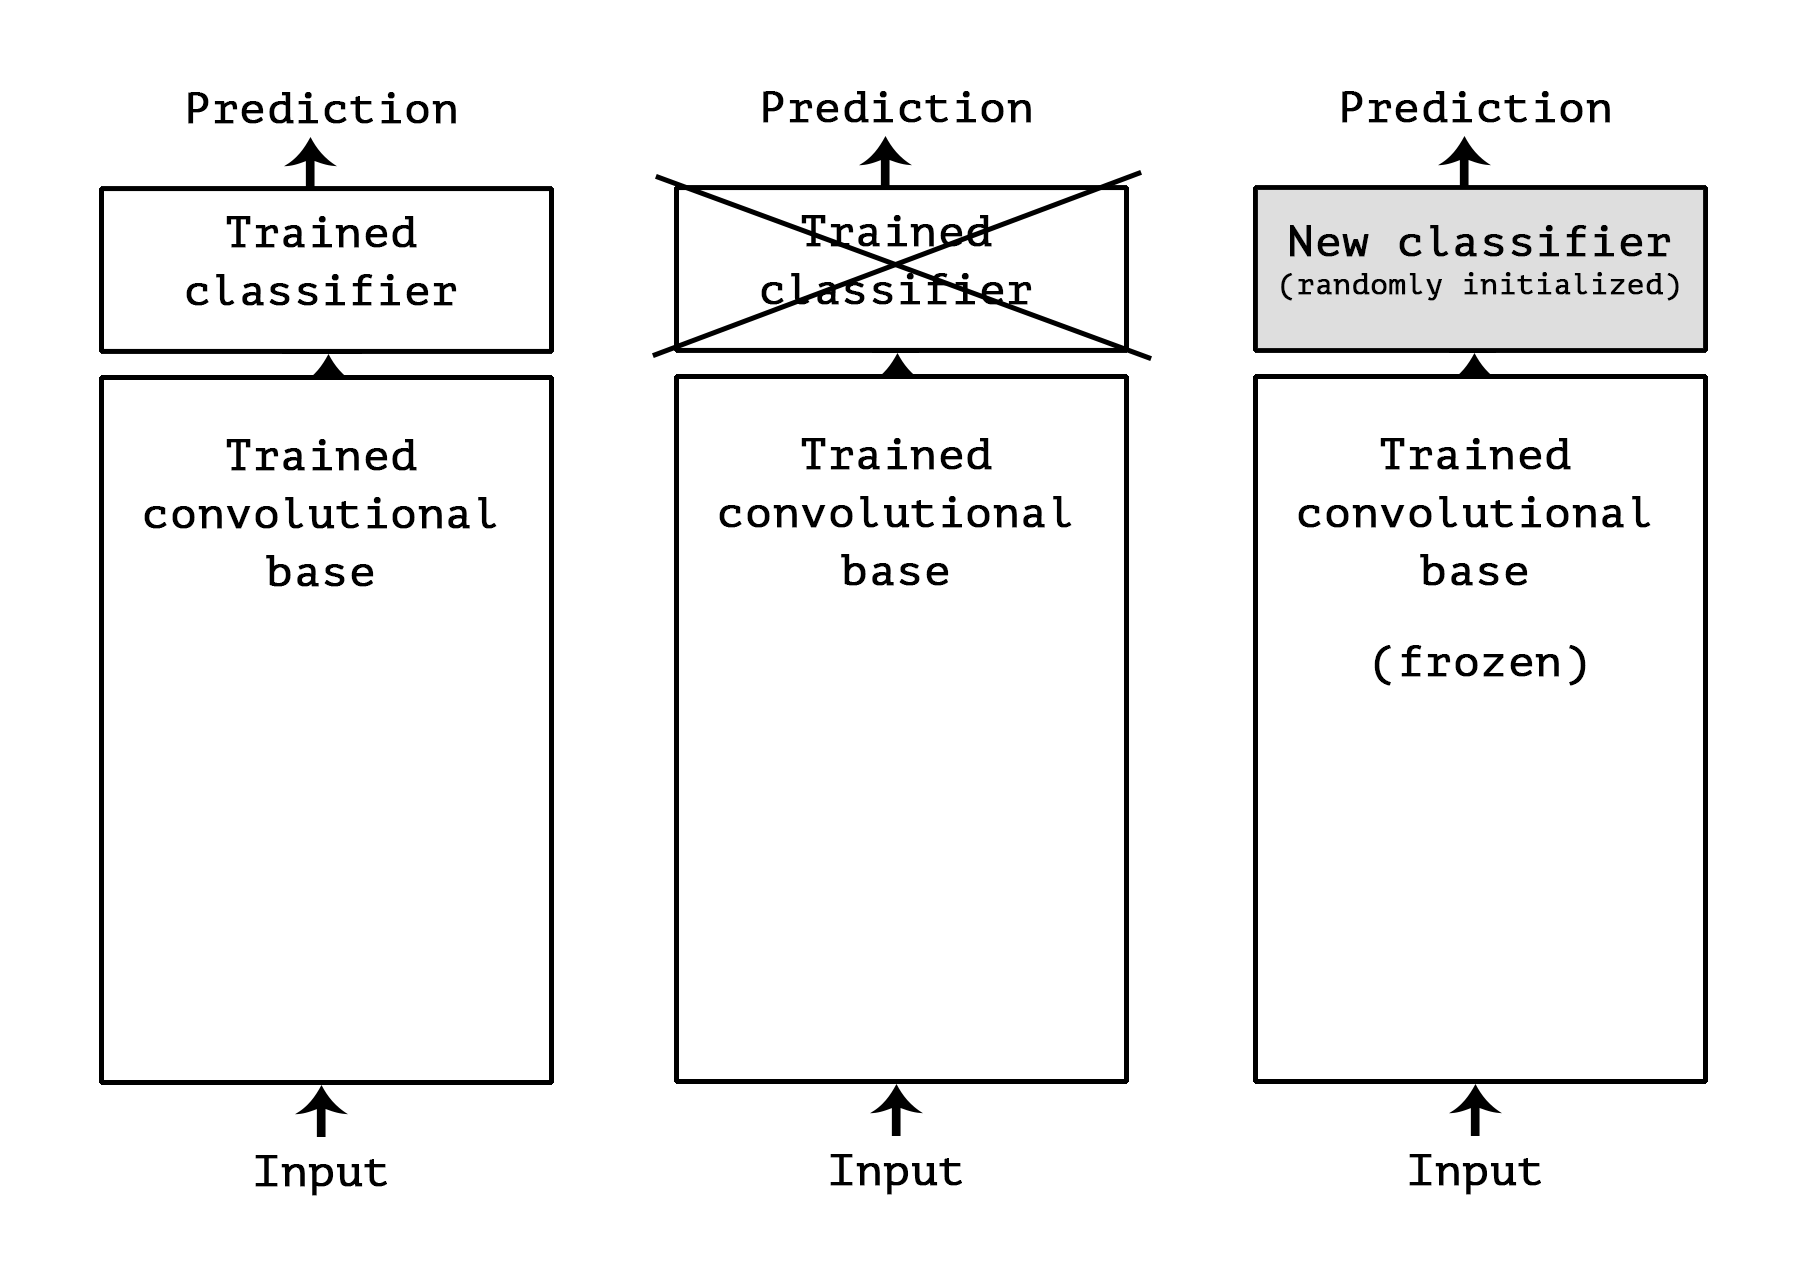

**0. Model**

In [ ]:
VGG_model = models.vgg16(pretrained=True)

**1. Freeze Weights**

In [ ]:
for name, param in VGG_model.named_parameters():
  param.requires_grad = False

**2. Rewrite Classifier:**  
As we can see from the output shape of the previous model, it classifies the image into 1000 classes. To make the model fit to our binary classification case, let's rewrite the classifier:

In [ ]:
# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [ ]:
VGG_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**3. Train the model**

In [ ]:
history = train_model(VGG_model, train_data, valid_data, device, batch_size=32, epochs=30, lr=0.000001)

Training Start
Epoch:1 / 30, train loss:0.6845 train_acc:0.5812, valid loss:0.6723 valid acc:0.7227
Epoch:2 / 30, train loss:0.6610 train_acc:0.7543, valid loss:0.6409 valid acc:0.7878
Epoch:3 / 30, train loss:0.6197 train_acc:0.7995, valid loss:0.5895 valid acc:0.7969
Epoch:4 / 30, train loss:0.5724 train_acc:0.8095, valid loss:0.5368 valid acc:0.7969
Epoch:5 / 30, train loss:0.5204 train_acc:0.8125, valid loss:0.5003 valid acc:0.8099
Epoch:6 / 30, train loss:0.4792 train_acc:0.8251, valid loss:0.4536 valid acc:0.8138
Epoch:7 / 30, train loss:0.4411 train_acc:0.8342, valid loss:0.4293 valid acc:0.8281
Epoch:8 / 30, train loss:0.4197 train_acc:0.8325, valid loss:0.4076 valid acc:0.8229
Epoch:9 / 30, train loss:0.3978 train_acc:0.8385, valid loss:0.4001 valid acc:0.8268
Epoch:10 / 30, train loss:0.3864 train_acc:0.8451, valid loss:0.3692 valid acc:0.8607
Epoch:11 / 30, train loss:0.3674 train_acc:0.8529, valid loss:0.3578 valid acc:0.8490
Epoch:12 / 30, train loss:0.3498 train_acc:0.849

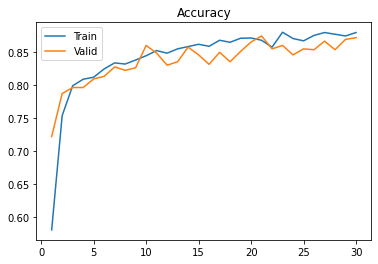

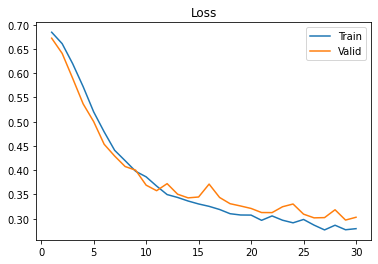

In [ ]:
# acc
plt.plot(range(1, 31), history['train_acc'], label='Train')
plt.plot(range(1, 31), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

# loss
plt.plot(range(1, 31), history['train_loss'], label='Train')
plt.plot(range(1, 31), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

## Fine-turning the Model: Weights are not frozen

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

**1. Freeze the layers:**

We will fine-tune the last 3 convolutional layers, why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 3 layers in the convolutional base.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

**0. Model**

In [ ]:
# get a new model
import torchvision.models as models

VGG_model = models.vgg16(pretrained=True)

print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**1. Freeze the weights except for the top 3 layers**

In [ ]:
for name, param in VGG_model.named_parameters():
  print(f'Name {name}')

Name features.0.weight
Name features.0.bias
Name features.2.weight
Name features.2.bias
Name features.5.weight
Name features.5.bias
Name features.7.weight
Name features.7.bias
Name features.10.weight
Name features.10.bias
Name features.12.weight
Name features.12.bias
Name features.14.weight
Name features.14.bias
Name features.17.weight
Name features.17.bias
Name features.19.weight
Name features.19.bias
Name features.21.weight
Name features.21.bias
Name features.24.weight
Name features.24.bias
Name features.26.weight
Name features.26.bias
Name features.28.weight
Name features.28.bias
Name classifier.0.weight
Name classifier.0.bias
Name classifier.3.weight
Name classifier.3.bias
Name classifier.6.weight
Name classifier.6.bias


Freeze:

In [ ]:
layers_not_to_freeze = ['24', '26', '28']

for name, param in VGG_model.named_parameters():
    layer_type, layer_index = name.split('.')[0], name.split('.')[1]

    if layer_type != "classifier":
        if layer_index not in layers_not_to_freeze:
            print(f"Layer {layer_index}: {name} freezed")
            param.requires_grad = False
        else:
            print(f"Layer {layer_index}: {name} not freezed")
            param.requires_grad = True

Layer 0: features.0.weight freezed
Layer 0: features.0.bias freezed
Layer 2: features.2.weight freezed
Layer 2: features.2.bias freezed
Layer 5: features.5.weight freezed
Layer 5: features.5.bias freezed
Layer 7: features.7.weight freezed
Layer 7: features.7.bias freezed
Layer 10: features.10.weight freezed
Layer 10: features.10.bias freezed
Layer 12: features.12.weight freezed
Layer 12: features.12.bias freezed
Layer 14: features.14.weight freezed
Layer 14: features.14.bias freezed
Layer 17: features.17.weight freezed
Layer 17: features.17.bias freezed
Layer 19: features.19.weight freezed
Layer 19: features.19.bias freezed
Layer 21: features.21.weight freezed
Layer 21: features.21.bias freezed
Layer 24: features.24.weight not freezed
Layer 24: features.24.bias not freezed
Layer 26: features.26.weight not freezed
Layer 26: features.26.bias not freezed
Layer 28: features.28.weight not freezed
Layer 28: features.28.bias not freezed


**2. Rewrite the classifier:**


In [ ]:
# define out classifier
binary_classifier = nn.Sequential(
   nn.Linear(in_features=25088, out_features=2048),
   nn.ReLU(),
   nn.Linear(in_features=2048, out_features=1024),
   nn.ReLU(),
   nn.Linear(in_features=1024, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=1)
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier

In [ ]:
VGG_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**2. Train the model:**

In [ ]:
history = train_model(VGG_model, train_data, valid_data, device, batch_size=32, epochs=30, lr=0.000001)

Training Start


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1 / 30, train loss:0.6879 train_acc:0.6357, valid loss:0.6821 valid acc:0.7115
Epoch:2 / 30, train loss:0.6763 train_acc:0.7204, valid loss:0.6675 valid acc:0.7139
Epoch:3 / 30, train loss:0.6534 train_acc:0.7854, valid loss:0.6405 valid acc:0.7716
Epoch:4 / 30, train loss:0.6102 train_acc:0.7928, valid loss:0.5917 valid acc:0.7861
Epoch:5 / 30, train loss:0.5496 train_acc:0.8010, valid loss:0.5107 valid acc:0.8077
Epoch:6 / 30, train loss:0.4763 train_acc:0.8347, valid loss:0.4456 valid acc:0.8149
Epoch:7 / 30, train loss:0.4200 train_acc:0.8248, valid loss:0.4041 valid acc:0.8053
Epoch:8 / 30, train loss:0.3732 train_acc:0.8388, valid loss:0.3657 valid acc:0.8462
Epoch:9 / 30, train loss:0.3343 train_acc:0.8635, valid loss:0.3490 valid acc:0.8341
Epoch:10 / 30, train loss:0.3201 train_acc:0.8561, valid loss:0.3300 valid acc:0.8558
Epoch:11 / 30, train loss:0.2875 train_acc:0.8668, valid loss:0.3077 valid acc:0.8341
Epoch:12 / 30, train loss:0.2653 train_acc:0.8906, valid loss:0

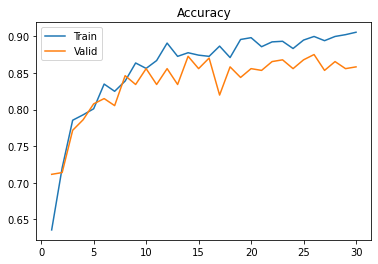

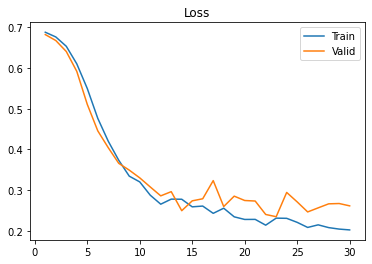

In [ ]:
# acc
plt.plot(range(1, 31), history['train_acc'], label='Train')
plt.plot(range(1, 31), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

# loss
plt.plot(range(1, 31), history['train_loss'], label='Train')
plt.plot(range(1, 31), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()